### JESTER JOKE RECOMMENDER SYSTEM 
##### &emsp;&emsp;- ALS MATRIX FACTORIZATION COLLABORATIVE FILTERING 
##### _Over 1.7 million ratings of 150 jokes from 59,132 users_
Xuyang Ji <br> Mar 9st, 2023

>_Data Abstract: The dataset "jester_ratings.csv", collected between Nov 2006 - May 2009, contains over 1.7 million continuous ratings (-10.00 to +10.00) of 150 jokes from 59,132 users, where each row is formatted as userID, itemID, and ratings. The dataset "jester_item.csv" maps item ID to the actual text of the jokes._

In [1]:
import os
os.getcwd()

'/Users/celine/Desktop/JESTER DS'

In [2]:
from pyspark import SQLContext, SparkContext
from pyspark.sql.functions import isnan, count, col
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing # for normalization 
from collections import Counter #finding the majority 
%matplotlib inline

In [3]:
sc= SparkContext()
sqlContext= SQLContext(sc)
rating_df= sqlContext.read.csv("jester_ratings.csv", header= True, inferSchema=True)
items_df= sqlContext.read.csv("jester_items.csv", header=True, inferSchema=True)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/30 13:44:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


/Users/celine/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [4]:
print("Ratings dataset shape:", (rating_df.count(), len(rating_df.columns)))
rating_df.show(5)

Ratings dataset shape: (1761439, 3)
+------+------+-------------------+
|userId|jokeId|             rating|
+------+------+-------------------+
|     1|     5|0.21899999999999997|
|     1|     7|             -9.281|
|     1|     8|             -9.281|
|     1|    13| -6.781000000000001|
|     1|    15|              0.875|
+------+------+-------------------+
only showing top 5 rows



In [5]:
items_df.printSchema()

root
 |-- jokeId: string (nullable = true)
 |-- jokeText: string (nullable = true)



In [6]:
print("Number of unique users: ", rating_df.select("userId").distinct().count())
print("Number of unique jokes: ", rating_df.select("jokeId").distinct().count())
print("Total number of ratings: ", rating_df.count())

23/04/30 13:45:11 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


Number of unique users:  59132


Number of unique jokes:  140
Total number of ratings:  1761439


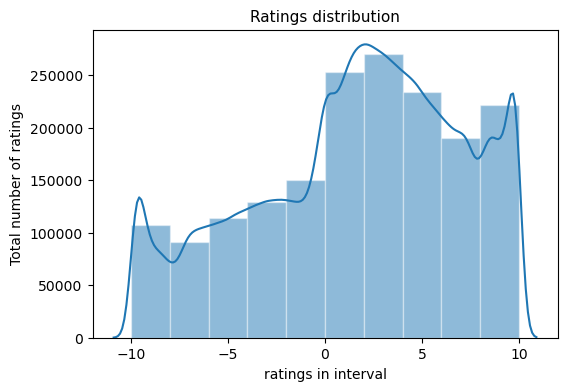

In [7]:
fig, ax = plt.subplots(figsize=(6,4))
ax.set_title('Ratings distribution', fontsize=11)
sns.histplot(rating_df.toPandas()['rating'], kde=True,stat="count",bins = 10,kde_kws=dict(cut=3),edgecolor=(1,1,1,.4))
ax.set_xlabel("ratings in interval")
ax.set_ylabel("Total number of ratings")
plt.show()

In [8]:
ratings_per_user = rating_df.groupby('userId').agg({"rating":"count"})
ratings_per_user.describe().show()

+-------+------------------+------------------+
|summary|            userId|     count(rating)|
+-------+------------------+------------------+
|  count|             59132|             59132|
|   mean|31967.599996617737|29.788253399174728|
| stddev|  18330.1688791294|32.801761409803056|
|    min|                 1|                 1|
|    max|             63978|               140|
+-------+------------------+------------------+



In [9]:
ratings_per_joke = rating_df.groupby('jokeId').agg({"rating":"count"})
ratings_per_joke.describe().show()

+-------+------------------+------------------+
|summary|            jokeId|     count(rating)|
+-------+------------------+------------------+
|  count|               140|               140|
|   mean| 80.37857142857143|12581.707142857143|
| stddev|40.771951823508005|11866.405872802346|
|    min|                 5|               166|
|    max|               150|             59122|
+-------+------------------+------------------+



In [10]:
X_train, X_test = rating_df.randomSplit([0.8,0.2],961)   # 80:20 ratio
print("Training data size : ", X_train.count())
print("Test data size : ", X_test.count())
print("Number of unique users in Training set", X_train[["userId"]].distinct().count())
print("Number of unique users in Test set", X_test[["userId"]].distinct().count())

Training data size :  1409051


Test data size :  352388


Number of unique users in Training set 58811


Number of unique users in Test set 52610


##### Alternating Least Square (ALS) with Spark ML
Alternating Least Square (ALS) is a matrix factorization algorithm using L2 regularization and it runs itself in a parallel fashion. ALS is implemented in Apache Spark ML and built for a larges-scale collaborative filtering problems. ALS is doing a pretty good job at solving scalability and sparseness of the Ratings data, and it’s simple and scales well to very large datasets.

Meantime, ALS minimizes two loss functions alternatively. It first holds user matrix fixed and runs gradient descent with item matrix; then it holds item matrix fixed and runs gradient descent with user matrix. 

Tuning ALS hyper-parameters via cross-validation:
* maxIter: the maximum number of iterations to run (defaults to 10)
* rank: the number of latent factors in the model (defaults to 10)
* regParam: the regularization parameter in ALS (defaults to 1.0)

In [11]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [12]:
def tune_ALS(train_data, validation_data, maxIter, regParams, ranks):
    """
    grid search function to select the best model based on RMSE of validation data
    ----------
    maxIter: int, max number of learning iterations
    regParams: list of float, one dimension of hyper-param tuning grid
    ranks: list of float, one dimension of hyper-param tuning grid
    ------
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    tuning_df= pd.DataFrame(columns=["Rank","Reg","RMSE"])
    for rank in ranks:
        for reg in regParams:
            # get ALS model
            als = ALS(userCol="userId",itemCol="jokeId",ratingCol="rating", coldStartStrategy="drop", nonnegative=True).setMaxIter(maxIter).setRank(rank).setRegParam(reg)
            # train ALS model
            model = als.fit(train_data)
            # evaluate the model by computing the RMSE on the validation data
            predictions = model.transform(validation_data)
            evaluator = RegressionEvaluator(metricName="rmse",
                                            labelCol="rating",
                                            predictionCol="prediction")
            rmse = evaluator.evaluate(predictions)
            tuning_df= tuning_df.append({'Rank':rank, 'Reg':reg, 'RMSE':rmse}, ignore_index=True)
            if rmse < min_error:
                min_error = rmse
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}, with a RMSE of {}'.format(best_rank, best_regularization, min_error))
    tuning_df.set_index('Rank',inplace=True)
    fig, ax=plt.subplots(figsize=(9,5))
    tuning_df.groupby('Reg')["RMSE"].plot(legend=True)
    plt.show()
    return best_model

23/04/30 13:46:47 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/04/30 13:46:47 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
23/04/30 13:46:47 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS



The best model has 13 latent factors and regularization = 0.375, with a RMSE of 4.433810545221143


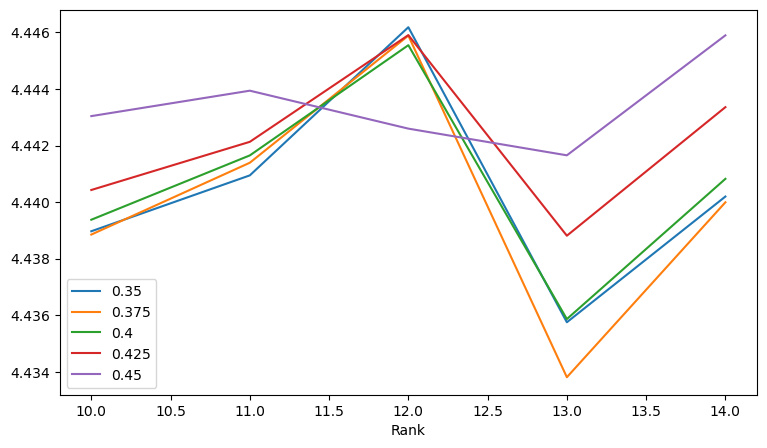

In [13]:
regParam= np.linspace(0.35,0.45,5)
rank= np.arange(10,15)
bModel= tune_ALS(X_train, X_test,10,regParam, rank)

In [22]:
def get_personalized_recommendations_for_user(bModel, user_id):
    # Generate top 10 recommendations for all users
    all_recs = bModel.recommendForAllUsers(10)
    user_recs = all_recs.filter(col('userId') == user_id)
    recommendations_df = make_recommendations_dataframe(user_recs)
    full_df = recommendations_df.join(items_df, 
                                       recommendations_df.jokeId == items_df.jokeId,
                                       "inner").drop(items_df.jokeId)
    full_df.show(10)
    
def make_recommendations_dataframe(recs):
    # Select the 'jokeId' and 'rating' columns from the recommendations DataFrame
    recs = recs.select('recommendations.jokeId', 'recommendations.rating')
    jokes = recs.select('jokeId').toPandas().iloc[0, 0]  
    ratings = recs.select('rating').toPandas().iloc[0, 0] 
    ratings_matrix = pd.DataFrame(jokes, columns=['jokeId'])
    ratings_matrix['ratings'] = ratings
    ratings_matrix_spark = sqlContext.createDataFrame(ratings_matrix)
    
    return ratings_matrix_spark


In [23]:
get_personalized_recommendations_for_user(bModel,8)

+------+------------------+--------------------+
|jokeId|           ratings|            jokeText|
+------+------------------+--------------------+
|   127| 2.867767333984375|"A little boy goe...|
|   132| 2.751760721206665|"Mickey Mouse is ...|
|    53| 2.750836133956909|One Sunday mornin...|
|    35| 2.737020969390869|An explorer in th...|
|    29|2.7220447063446045|An old Scotsmen i...|
|    31|2.6889419555664062| President Clinto...|
|    50|2.6548125743865967|"A guy goes into ...|
|   125|2.6497316360473633|"An American tour...|
|    65| 2.633878469467163|Two Rednecks were...|
|    69| 2.621914863586426|"This guys wife a...|
+------+------------------+--------------------+



In [24]:
sc.stop()